In [21]:
import stim
import numpy as np
import pymatching
import sinter
import matplotlib.pyplot as plt

In [22]:
data_qubit_coords={(2,0):1,(2,2):2,(2,4):3,(4,4):4,(0,6):5,(2,6):6,(4,6):7,(4,0):8,(6,0):9, (4,2):10, (6,2):11}
ancilla_qubit_coords={(1,4):12, (3,2):13, (3, 5):14, (5,4):15, (5,1):16, (1,6):17, (2,3):18, (4,3):19, (3,0):20, (6,1):21, (1,4):22, (3,2):23, (3, 5):24, (5,4):25, (5,1):26, 27: (4, 1)}
color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
color_face_X_stabilizer = {22: (2, 3, 5, 6), 23: (1, 2, 3, 4), 24: (3, 4, 6, 7)}
edge_X_stabilizer = {17: (5,6), 18: (2,3), 19: (4,10), 20: (1,8)}
surface_face_X_stabilizer = {24: (3, 4, 6, 7), 26: (8, 9, 10, 11)}
surface_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 15: (4,7,10,11)}
surface_edge_Z_stabilizer = {21: (9,11)}
bell_state_stabilizer={27: (8,10)}

In [23]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# キュービットの座標とインデックスの定義
def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4)
    }

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval = False):
    # CNOTゲートの適用の前後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")

    # CNOTゲートの適用
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                else:
                    circuit.append("CX", [data_qubit, ancilla])
        circuit.append("TICK")

    # CNOTゲートの後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")

    # MR命令を追加
    for ancilla in stabilizer.keys():
        circuit.append("MR", [ancilla])
    circuit.append("TICK")  # MR命令と他の操作を分離

    # DETECTORの追加
    if add_detector:
        if not interval:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx), stim.target_rec(-len(stabilizer) + idx)])
        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]  # データキュービットのリストを作成
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]  # アンシラキュービットのリストを作成

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    step_1={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 15: (4, 7, 10, 11), 22: (8, 10), 21: (9, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (2, 3, 5, 6), 15: (4, 7, 10, 11), 21: (9, 11), 22: (8, 10), 23: (1, 2), 24: (3, 4)}


    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, )
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True)
    

    append_syndrome_measurement(circuit, step_1)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-2), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-1)])

    append_syndrome_measurement(circuit, step_2, is_X_stabilizer=True)
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-16), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-4)])

    append_syndrome_measurement(circuit, floquet_Z)
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-16)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-13)])

    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-17)])

    for i in range(3):
        append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True)
        append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True)



    # 回路の表示
    print(circuit)

QUBIT_COORDS(2, 0) 1
QUBIT_COORDS(2, 2) 2
QUBIT_COORDS(2, 4) 3
QUBIT_COORDS(4, 4) 4
QUBIT_COORDS(0, 6) 5
QUBIT_COORDS(2, 6) 6
QUBIT_COORDS(4, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(6, 0) 9
QUBIT_COORDS(4, 2) 10
QUBIT_COORDS(6, 2) 11
QUBIT_COORDS(1, 4) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(3, 6) 14
QUBIT_COORDS(5, 4) 15
QUBIT_COORDS(5, 0) 16
QUBIT_COORDS(1, 6) 17
QUBIT_COORDS(2, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(3, 0) 20
QUBIT_COORDS(6, 1) 21
QUBIT_COORDS(4, 1) 22
QUBIT_COORDS(2, 1) 23
QUBIT_COORDS(3, 4) 24
R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
TICK
H 12 13 14
TICK
CX 12 2 13 1 14 3
TICK
CX 12 3 13 2 14 4
TICK
CX 12 5 13 3 14 6
TICK
CX 12 6 13 4 14 7
TICK
H 12 13 14
TICK
MR 12 13 14
TICK
CX 2 12 1 13 3 14
TICK
CX 3 12 2 13 4 14
TICK
CX 5 12 3 13 6 14
TICK
CX 6 12 4 13 7 14
TICK
MR 12 13 14
TICK
DETECTOR rec[-3] rec[-3]
DETECTOR rec[-2] rec[-2]
DETECTOR rec[-1] rec[-1]
CX 2 12 1 13 3 14 8 16
TICK
CX 3 12 2 13 4 14 9 16
TICK
CX 5 12 3 13 6 14 10 16
TICK
C

In [24]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4)
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], 0)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], 0)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR
        circuit.append("MR", [ancilla])
        circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
        circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if not interval:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx), stim.target_rec(-len(stabilizer) + idx)])
        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

if __name__ == "__main__":
    p = 0.01  # Depolarize noise probability
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 5, 3, 6), 13: (3, 10, 1, 4, 8, 2), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, noise_prob=0)
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True, noise_prob=0)

    append_syndrome_measurement(circuit, step_1, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-2), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-1)])

    append_syndrome_measurement(circuit, step_2, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-16), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-4)])

    append_syndrome_measurement(circuit, floquet_Z, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-16)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-13)])

    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-17)])

    for i in range(0):
        append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
        append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p)
    
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
    circuit.append("M", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-7),], 0)
    circuit.append("DETECTOR", [stim.target_rec(-17), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-16), stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)])
    circuit.append("DETECTOR", [stim.target_rec(-15), stim.target_rec(-14), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-7), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2)])


    print(circuit)


QUBIT_COORDS(2, 0) 1
QUBIT_COORDS(2, 2) 2
QUBIT_COORDS(2, 4) 3
QUBIT_COORDS(4, 4) 4
QUBIT_COORDS(0, 6) 5
QUBIT_COORDS(2, 6) 6
QUBIT_COORDS(4, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(6, 0) 9
QUBIT_COORDS(4, 2) 10
QUBIT_COORDS(6, 2) 11
QUBIT_COORDS(1, 4) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(3, 6) 14
QUBIT_COORDS(5, 4) 15
QUBIT_COORDS(5, 0) 16
QUBIT_COORDS(1, 6) 17
QUBIT_COORDS(2, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(3, 0) 20
QUBIT_COORDS(6, 1) 21
QUBIT_COORDS(4, 1) 22
QUBIT_COORDS(2, 1) 23
QUBIT_COORDS(3, 4) 24
R 1
X_ERROR(0) 1
R 2
X_ERROR(0) 2
R 3
X_ERROR(0) 3
R 4
X_ERROR(0) 4
R 5
X_ERROR(0) 5
R 6
X_ERROR(0) 6
R 7
X_ERROR(0) 7
R 8
X_ERROR(0) 8
R 9
X_ERROR(0) 9
R 10
X_ERROR(0) 10
R 11
X_ERROR(0) 11
R 12
X_ERROR(0) 12
R 13
X_ERROR(0) 13
R 14
X_ERROR(0) 14
R 15
X_ERROR(0) 15
R 16
X_ERROR(0) 16
R 17
X_ERROR(0) 17
R 18
X_ERROR(0) 18
R 19
X_ERROR(0) 19
R 20
X_ERROR(0) 20
R 21
X_ERROR(0) 21
R 22
X_ERROR(0) 22
R 23
X_ERROR(0) 23
R 24
X_ERROR(0) 24
TICK
H 12
DEPOLARIZE1(0) 12
H 13
DEPOLARIZE

In [25]:
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [26]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.0013387) D3 D4 D5
    error(0.0013387) D3 D4 D5 D7 D8 D9
    error(0.000669799) D3 D4 D7 D8 D9 L0
    error(0.000669799) D3 D4 D7 D8 L0
    error(0.000669799) D3 D4 D9 L0
    error(0.000669799) D3 D4 L0
    error(0.000669799) D3 D5
    error(0.00267382) D3 D5 D7 D8 D9 D12
    error(0.000669799) D3 D5 D8
    error(0.000669799) D3 D5 D8 D9
    error(0.000669799) D3 D5 D9
    error(0.00267382) D3 D5 D12
    error(0.00200671) D3 D7 D8 D9 D10
    error(0.00267382) D3 D7 D8 D9 D11 D12
    error(0.000669799) D3 D7 D8 D10
    error(0.000669799) D3 D8 D9 D10
    error(0.00200671) D3 D8 D10
    error(0.0013387) D3 D8 L0
    error(0.0013387) D3 D9 D10
    error(0.0139253) D3 D10
    error(0.00267382) D3 D11 D12
    error(0.0013387) D3 L0
    error(0.000669799) D4 D5
    error(0.000669799) D4 D5 D7 D8 D9
    error(0.000669799) D4 D5 D7 D9
    error(0.000669799) D4 D5 D8
    error(0.00400536) D4 D6
    error(0.0013387) D4 D6 D7 D8 D9
    error(0.000669799) D4

In [27]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4)
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], 0)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], 0)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR
        circuit.append("MR", [ancilla])
        circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
        circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if not interval:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx), stim.target_rec(-len(stabilizer) + idx)])
        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

def main(d, p):
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 5, 3, 6), 13: (3, 10, 1, 4, 8, 2), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, noise_prob=0)
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True, noise_prob=0)

    append_syndrome_measurement(circuit, step_1, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-2), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-1)])

    append_syndrome_measurement(circuit, step_2, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-16), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-4)])

    append_syndrome_measurement(circuit, floquet_Z, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-16)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-13)])

    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-17)])

    for i in range(0):
        append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
        append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p)
    
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
    circuit.append("M", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-7),], 0)
    circuit.append("DETECTOR", [stim.target_rec(-17), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-16), stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)])
    circuit.append("DETECTOR", [stim.target_rec(-15), stim.target_rec(-14), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-7), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2)])


    return circuit


In [46]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4)
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], 0)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], 0)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR
        circuit.append("MR", [ancilla])
        circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
        circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if not interval:
            circuit.append("DETECTOR", [stim.target_rec(-4)])
            circuit.append("DETECTOR", [stim.target_rec(-6)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2)])
            circuit.append("DETECTOR", [stim.target_rec(-5)])

        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

def main_1(d, p):
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 5, 3, 6), 13: (3, 10, 1, 4, 8, 2), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")

    append_syndrome_measurement(circuit,floquet_X, is_X_stabilizer=True, noise_prob=p)
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=False,  noise_prob=p)

    for i in range(1):
         append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p)
         append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
        
    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p)
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
    circuit.append("M", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-7),], 0)
    circuit.append("DETECTOR", [stim.target_rec(-17), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-16), stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)])
    circuit.append("DETECTOR", [stim.target_rec(-15), stim.target_rec(-14), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-7), stim.target_rec(-6)])
    circuit.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2)])


    return circuit

In [47]:
circuit = main_1(3, 0)
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [30]:
# import math
# num_shot = 10000000
# x_list = []
# y_list = []
# for m in range(30): 
#     noise = (m+1)*5e-5
#     sampler = main(3, noise).compile_detector_sampler()

#     num_sample_list = sampler.sample(num_shot, separate_observables=True)
#     fail = 0
#     for i, row in enumerate(num_sample_list[0]):
#         is_all_false = not row.any()
#         if is_all_false and num_sample_list[1][i][0]:
#             fail += 1
#     x_list.append(noise)
#     y_list.append(fail/num_shot)
#     print(str(fail) + "/" + str(num_shot) + " " + f"{(fail/num_shot):.10f}")
    
# plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')

In [31]:
# import math
# import numpy as np
# import matplotlib.pyplot as plt

# num_shot = 10_000_000_0
# x_list = []
# y_list = []

# # 事前にmain関数のインスタンス化が可能であれば行う（仮）
# # 例: main_instance = main(3)
# # ただし、noiseが変わるため各ループでのコンパイルは避けられない場合もあります

# for m in range(30): 
#     noise = (m + 1) * 5e-5
#     sampler = main(3, noise).compile_detector_sampler()
    
#     # サンプリング結果をNumPy配列として取得
#     samples, observables = sampler.sample(num_shot, separate_observables=True)
    
#     # 可能であれば、データ型を適切に設定（例: bool, int8など）
#     samples = np.array(samples, dtype=bool)       # 仮定: samplesはブール値
#     observables = np.array(observables, dtype=bool)  # 仮定: observablesもブール値
    
#     # ベクトル化された条件判定
#     is_all_false = ~samples.any(axis=1)          # 各行がすべてFalseか
#     fail = np.sum(is_all_false & observables[:, 0])  # 条件を満たすものをカウント
    
#     x_list.append(noise)
#     y_list.append(fail / num_shot)
#     print(f"{fail}/{num_shot} {fail / num_shot:.10f}")

# # プロット
# plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
# plt.xlabel('Noise')
# plt.ylabel('Fail Rate')
# plt.title('Fail Rate vs Noise')
# plt.legend()
# plt.grid(True)
# plt.show()


In [32]:
# def main_sequential():
#     num_shot = 10_000_000
#     num_iterations = 100
#     x_list = []
#     y_list = []
    
#     for m in range(num_iterations):
#         noise = (m + 20) * 5e-5
#         try:
#             sampler = main(3, noise).compile_detector_sampler()
            
#             # サンプリング結果を取得
#             samples, observables = sampler.sample(num_shot, separate_observables=True)
            
#             # NumPy 配列に変換
#             samples = np.array(samples, dtype=bool)
#             observables = np.array(observables, dtype=bool)
            
#             # ベクトル化された条件判定
#             is_all_false = ~samples.any(axis=1)
#             fail = np.sum(is_all_false & observables[:, 0])
            
#             fail_rate = fail / num_shot
#             x_list.append(noise)
#             y_list.append(fail_rate)
#             print(f"{fail}/{num_shot} {fail_rate:.10f} (Noise: {noise})")
#         except Exception as e:
#             print(f"m={m} でエラーが発生しました: {e}", file=sys.stderr)
#             traceback.print_exc()
    
#     if not x_list or not y_list:
#         print("エラー: すべてのタスクが失敗したか、結果がありません。", file=sys.stderr)
#         return
    
#     # ノイズ値でソート（オプション）
#     sorted_pairs = sorted(zip(x_list, y_list))
    
#     try:
#         x_list, y_list = zip(*sorted_pairs)
#     except ValueError as ve:
#         print(f"データのアンパック中にエラーが発生しました: {ve}", file=sys.stderr)
#         return
    
#     # プロット
#     plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
#     plt.xlabel('Noise')
#     plt.ylabel('Fail Rate')
#     plt.title('Fail Rate vs Noise')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# if __name__ == "__main__":
#     main_sequential()


In [33]:
# import math
# import numpy as np
# import cupy as cp  # CuPyをインポート
# import matplotlib.pyplot as plt
# import traceback
# import sys

# # 必要に応じて、並列処理を見直す
# # ここではシーケンシャル処理を維持します

# def main_sequential_gpu():
#     num_shot = 100_000_000
#     num_iterations = 30
#     x_list = []
#     y_list = []
    
#     for m in range(num_iterations):
#         noise = (m + 20) * 5e-5
#         try:
#             sampler = main(3, noise).compile_detector_sampler()
            
#             # サンプリング結果を取得
#             samples, observables = sampler.sample(num_shot, separate_observables=True)
            
#             # NumPy配列からCuPy配列に変換（GPUメモリに転送）
#             samples_gpu = cp.asarray(samples, dtype=bool)
#             observables_gpu = cp.asarray(observables, dtype=bool)
            
#             # ベクトル化された条件判定をGPU上で実行
#             is_all_false = ~cp.any(samples_gpu, axis=1)
#             fail = cp.sum(is_all_false & observables_gpu[:, 0])
            
#             # 結果をCPUに転送
#             fail = fail.get()
#             fail_rate = fail / num_shot
#             x_list.append(noise)
#             y_list.append(fail_rate)
#             print(f"{fail}/{num_shot} {fail_rate:.10f} (Noise: {noise})")
#         except Exception as e:
#             print(f"m={m} でエラーが発生しました: {e}", file=sys.stderr)
#             traceback.print_exc()
    
#     if not x_list or not y_list:
#         print("エラー: すべてのタスクが失敗したか、結果がありません。", file=sys.stderr)
#         return
    
#     # ノイズ値でソート（オプション）
#     sorted_pairs = sorted(zip(x_list, y_list))
    
#     try:
#         x_list, y_list = zip(*sorted_pairs)
#     except ValueError as ve:
#         print(f"データのアンパック中にエラーが発生しました: {ve}", file=sys.stderr)
#         return
    
#     # プロット
#     plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
#     plt.xlabel('Noise')
#     plt.ylabel('Fail Rate')
#     plt.title('Fail Rate vs Noise')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# if __name__ == "__main__":
#     main_sequential_gpu()


In [34]:
# import numpy as np
# import cupy as cp  # CuPyをインポート
# import matplotlib.pyplot as plt
# import traceback
# import sys

# # 仮の main クラスの定義（実際の実装に置き換えてください）
# # from your_module import main

# def main_sequential_gpu_with_optimized_batch():
#     num_shot = 1_000_000_000
#     num_iterations = 50
#     x_list = []
#     y_list = []
#     batch_size = 5_000  # バッチサイズを500,000に設定（必要に応じて調整）

#     for m in range(num_iterations):
#         noise = (m + 1) * 5e-7
#         try:
#             sampler = main(3, noise).compile_detector_sampler()
            
#             # サンプリング結果を取得
#             samples, observables = sampler.sample(num_shot, separate_observables=True)
            
#             # バッチ処理のためにデータを分割
#             num_batches = num_shot // batch_size
#             fail = 0

#             for i in range(num_batches):
#                 start = i * batch_size
#                 end = start + batch_size
#                 samples_batch = samples[start:end]
#                 observables_batch = observables[start:end]
                
#                 # CuPy配列に変換
#                 samples_gpu = cp.asarray(samples_batch, dtype=bool)
#                 observables_gpu = cp.asarray(observables_batch, dtype=bool)
                
#                 # ベクトル化された条件判定をGPU上で実行
#                 is_all_false = ~cp.any(samples_gpu, axis=1)
#                 fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()
                
#                 # メモリを解放
#                 del samples_gpu, observables_gpu, is_all_false
#                 cp.get_default_memory_pool().free_all_blocks()
            
#             # 残りのデータを処理
#             remainder = num_shot % batch_size
#             if remainder > 0:
#                 samples_batch = samples[-remainder:]
#                 observables_batch = observables[-remainder:]
                
#                 samples_gpu = cp.asarray(samples_batch, dtype=bool)
#                 observables_gpu = cp.asarray(observables_batch, dtype=bool)
                
#                 is_all_false = ~cp.any(samples_gpu, axis=1)
#                 fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()
                
#                 # メモリを解放
#                 del samples_gpu, observables_gpu, is_all_false
#                 cp.get_default_memory_pool().free_all_blocks()
            
#             fail_rate = fail / num_shot
#             x_list.append(noise)
#             y_list.append(fail_rate)
#             print(f"{fail}/{num_shot} {fail_rate:.10f} (Noise: {noise})")
#         except cp.cuda.memory.OutOfMemoryError as mem_err:
#             print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
#             traceback.print_exc()
#         except Exception as e:
#             print(f"m={m} でエラーが発生しました: {e}", file=sys.stderr)
#             traceback.print_exc()

#     if not x_list or not y_list:
#         print("エラー: すべてのタスクが失敗したか、結果がありません。", file=sys.stderr)
#         return

#     # ノイズ値でソート（オプション）
#     sorted_pairs = sorted(zip(x_list, y_list))

#     try:
#         x_list, y_list = zip(*sorted_pairs)
#     except ValueError as ve:
#         print(f"データのアンパック中にエラーが発生しました: {ve}", file=sys.stderr)
#         return

#     # プロット
#     plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
#     plt.xlabel('Noise')
#     plt.ylabel('Fail Rate')
#     plt.title('Fail Rate vs Noise')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return x_list, y_list

# if __name__ == "__main__":
#     x_list, y_list = main_sequential_gpu_with_optimized_batch()


Iteration 0, Chunk 10/100 processed.
Iteration 0, Chunk 20/100 processed.
Iteration 0, Chunk 30/100 processed.
Iteration 0, Chunk 40/100 processed.
Iteration 0, Chunk 50/100 processed.
Iteration 0, Chunk 60/100 processed.
Iteration 0, Chunk 70/100 processed.
Iteration 0, Chunk 80/100 processed.
Iteration 0, Chunk 90/100 processed.
Iteration 0, Chunk 100/100 processed.
Iteration 0: 1/1000000000 = 0.0000000010 (Noise: 0.0005)
Iteration 1, Chunk 10/100 processed.
Iteration 1, Chunk 20/100 processed.
Iteration 1, Chunk 30/100 processed.
Iteration 1, Chunk 40/100 processed.
Iteration 1, Chunk 50/100 processed.
Iteration 1, Chunk 60/100 processed.
Iteration 1, Chunk 70/100 processed.
Iteration 1, Chunk 80/100 processed.
Iteration 1, Chunk 90/100 processed.
Iteration 1, Chunk 100/100 processed.
Iteration 1: 3/1000000000 = 0.0000000030 (Noise: 0.0006000000000000001)
Iteration 2, Chunk 10/100 processed.
Iteration 2, Chunk 20/100 processed.
Iteration 2, Chunk 30/100 processed.
Iteration 2, Chunk

c:\Users\Yuga Hirai\Documents\GitHub\invention\stim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuga Hirai\Documents\GitHub\invention\stim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuga Hirai\Documents\GitHub\invention\stim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


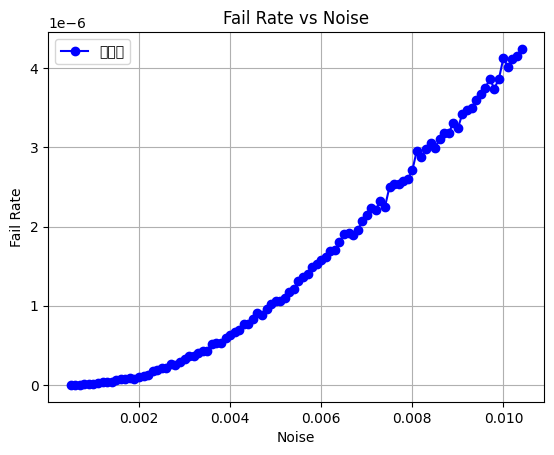

In [48]:
import numpy as np
import cupy as cp  # CuPyをインポート
import matplotlib.pyplot as plt
import traceback
import sys

# 仮の main クラスの定義（実際の実装に置き換えてください）
# from your_module import main

def main_sequential_gpu_with_chunked_sampling():
    total_num_shot = 1_000_000_000  # 総サンプル数: 10億
    num_iterations = 100  # 各ノイズレベルでのサンプリング回数
    x_list = []
    y_list = []
    chunk_size = 10_000_000  # チャンクサイズを10,000,000に設定（必要に応じて調整）
    num_chunks = total_num_shot // chunk_size  # チャンク数
    remainder_shot = total_num_shot % chunk_size  # 残りのサンプル数

    for m in range(num_iterations):
        noise = 5e-4 + m * 1e-4 
        try:
            sampler = main_1(3, noise).compile_detector_sampler()

            fail = 0  # 失敗カウントの初期化

            # チャンクごとのサンプリングと処理
            for i in range(num_chunks):
                current_chunk_size = chunk_size
                if i == num_chunks - 1 and remainder_shot > 0:
                    current_chunk_size += remainder_shot

                # サンプリング結果を取得（チャンク単位）
                samples_batch, observables_batch = sampler.sample(current_chunk_size, separate_observables=True)

                # CuPy配列に変換（dtypeをuint8に変更してメモリ使用量を削減）
                samples_gpu = cp.asarray(samples_batch, dtype=cp.uint8)
                observables_gpu = cp.asarray(observables_batch, dtype=cp.uint8)

                # ベクトル化された条件判定をGPU上で実行
                is_all_false = ~cp.any(samples_gpu, axis=1)
                fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()

                # メモリを解放
                del samples_gpu, observables_gpu, is_all_false
                cp.get_default_memory_pool().free_all_blocks()

                # 進捗表示（オプション）
                if (i + 1) % 10 == 0:
                    print(f"Iteration {m}, Chunk {i + 1}/{num_chunks} processed.")

            # 残りのサンプルを処理（必要に応じて）
            if remainder_shot > 0 and num_chunks == 0:
                samples_batch, observables_batch = sampler.sample(remainder_shot, separate_observables=True)

                samples_gpu = cp.asarray(samples_batch, dtype=cp.uint8)
                observables_gpu = cp.asarray(observables_batch, dtype=cp.uint8)

                is_all_false = ~cp.any(samples_gpu, axis=1)
                fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()

                # メモリを解放
                del samples_gpu, observables_gpu, is_all_false
                cp.get_default_memory_pool().free_all_blocks()

            fail_rate = fail / total_num_shot
            x_list.append(noise)
            y_list.append(fail_rate)
            print(f"Iteration {m}: {fail}/{total_num_shot} = {fail_rate:.10f} (Noise: {noise})")
        except cp.cuda.memory.OutOfMemoryError as mem_err:
            print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
            traceback.print_exc()
        except np.core._exceptions._ArrayMemoryError as mem_err:
            print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
            traceback.print_exc()
        except Exception as e:
            print(f"m={m} でエラーが発生しました: {e}", file=sys.stderr)
            traceback.print_exc()

    if not x_list or not y_list:
        print("エラー: すべてのタスクが失敗したか、結果がありません。", file=sys.stderr)
        return

    # ノイズ値でソート（オプション）
    sorted_pairs = sorted(zip(x_list, y_list))

    try:
        x_list, y_list = zip(*sorted_pairs)
    except ValueError as ve:
        print(f"データのアンパック中にエラーが発生しました: {ve}", file=sys.stderr)
        return

    # プロット
    plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
    plt.xlabel('Noise')
    plt.ylabel('Fail Rate')
    plt.title('Fail Rate vs Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_list, y_list

if __name__ == "__main__":
    x_list, y_list = main_sequential_gpu_with_chunked_sampling()


In [51]:
import numpy as np

# x_list と y_list を NumPy 配列に変換
x_array = np.array(x_list)
y_array = np.array(y_list)

# 2 列の配列に結合
data = np.column_stack((x_array, y_array))

np.savetxt('output.txt', data, fmt='%.10f', header='Noise FailRate', comments='')

データの読み込みに成功しました。
読み込んだデータの先頭:
          Noise      FailRate
0         Noise      FailRate
1  0.0005000000  0.0000000200
2  0.0006000000  0.0000000350
3  0.0007000000  0.0000000420
4  0.0008000000  0.0000000550
数値変換に失敗したデータが存在します。該当する行を除外します。
   Noise  FailRate
0    NaN       NaN
フィルタリング後のデータ数: 100


C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_30324\925568621.py:59: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_30324\925568621.py:59: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_30324\925568621.py:59: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_30324\925568621.py:59: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_30324\925568621.py:59: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_30324\925568621.py:59: UserWarning: Glyph 12531

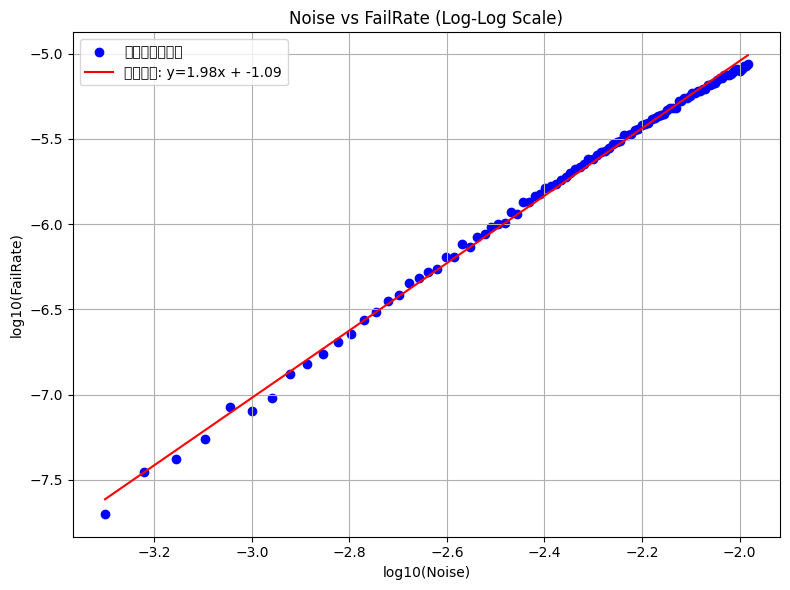

回帰直線の式: log10(FailRate) = 1.9762 * log10(Noise) + -1.0901
決定係数 (R^2): 0.9977


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# データを読み込む
# output.txt がスペース区切りで、最初の列が Noise、2 列目が FailRate と仮定
try:
    data = pd.read_csv('output_unf.txt', sep='\s+', header=None, names=['Noise', 'FailRate'])
    print("データの読み込みに成功しました。")
except Exception as e:
    print(f"データの読み込み中にエラーが発生しました: {e}")
    exit()

# データの最初の数行を表示して確認
print("読み込んだデータの先頭:")
print(data.head())

# 数値型に変換（エラーがある場合は NaN にする）
data['Noise'] = pd.to_numeric(data['Noise'], errors='coerce')
data['FailRate'] = pd.to_numeric(data['FailRate'], errors='coerce')

# 変換できなかったデータの確認
if data['Noise'].isnull().any() or data['FailRate'].isnull().any():
    print("数値変換に失敗したデータが存在します。該当する行を除外します。")
    print(data[data.isnull().any(axis=1)])

# NaN を含む行を除外
data = data.dropna(subset=['Noise', 'FailRate'])

# FailRate が0でないデータのみを選択
filtered_data = data[data['FailRate'] > 0]

# Noise が0でないことも確認（念のため）
filtered_data = filtered_data[filtered_data['Noise'] > 0]

# フィルタリング後のデータ数を表示
print(f"フィルタリング後のデータ数: {len(filtered_data)}")

# 対数変換
log_noise = np.log10(filtered_data['Noise'])
log_failrate = np.log10(filtered_data['FailRate'])

# 線形回帰（対数スケールで）
slope, intercept, r_value, p_value, std_err = stats.linregress(log_noise, log_failrate)

# 回帰直線の計算
regression_line = slope * log_noise + intercept

# プロット
plt.figure(figsize=(8,6))
plt.scatter(log_noise, log_failrate, color='blue', label='データポイント')
plt.plot(log_noise, regression_line, color='red', label=f'回帰直線: y={slope:.2f}x + {intercept:.2f}')
plt.xlabel('log10(Noise)')
plt.ylabel('log10(FailRate)')
plt.title('Noise vs FailRate (Log-Log Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 回帰結果の表示
print(f"回帰直線の式: log10(FailRate) = {slope:.4f} * log10(Noise) + {intercept:.4f}")
print(f"決定係数 (R^2): {r_value**2:.4f}")


In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
import stim  # Stimライブラリをインポート

num_shot = 1_000_000_000
x_list = []
y_list = []

for m in range(50): 
    noise = (m + 1) * 5e-7

    sampler = main(3, noise).compile_detector_sampler()
    num_sample_list = sampler.sample(num_shot, separate_observables=True)
    
    # NumPy配列への変換
    sampled_observables = np.array(num_sample_list[0], dtype=bool)
    detector_results = np.array(num_sample_list[1], dtype=bool)
    
    # ベクトル化された条件判定
    is_all_false = ~sampled_observables.any(axis=1)
    detector_condition = detector_results[:, 0]
    
    # failのカウント
    fail = np.sum(is_all_false & detector_condition)
    
    # 結果の保存
    x_list.append(noise)
    y_list.append(fail / num_shot)
    
    # 進捗の表示
    print(f"{fail}/{num_shot} {fail / num_shot:.10f}%")

# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='Fail Rate')
plt.xlabel('Noise')
plt.ylabel('Fail Rate')
plt.title('Fail Rate vs Noise')
plt.grid(True)
plt.legend()
plt.show()

MemoryError: Unable to allocate 31.7 GiB for an array with shape (1000000000, 34) and data type bool

In [29]:
x_list

NameError: name 'x_list' is not defined

In [ ]:
import cupy
print(cupy.__version__)

ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

CUDA Path: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6
DLL dependencies:
  KERNEL32.dll -> C:\Windows\System32\KERNEL32.DLL
  MSVCP140.dll -> C:\Windows\SYSTEM32\MSVCP140.dll
  VCRUNTIME140.dll -> C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\VCRUNTIME140.dll
  api-ms-win-crt-convert-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-environment-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-filesystem-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-heap-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-runtime-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-stdio-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-string-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  api-ms-win-crt-time-l1-1-0.dll -> C:\Windows\System32\ucrtbase.dll
  cuTENSOR.dll -> not found
  cublas64_12.dll -> C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6\bin\cublas64_12.dll
  cudnn64_8.dll -> not found
  cufft64_11.dll -> C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6\bin\cufft64_11.dll
  curand64_10.dll -> C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6\bin\curand64_10.dll
  cusolver64_11.dll -> C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6\bin\cusolver64_11.dll
  cusparse64_12.dll -> C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6\bin\cusparse64_12.dll
  nvrtc64_120_0.dll -> C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.6\bin\nvrtc64_120_0.dll
  python311.dll -> C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\python311.dll

Original error:
  ImportError: cannot import name _util
================================================================


In [27]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [352]:
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 9942 wrong predictions (logical errors) out of 100000 shots


In [353]:
import stim
import numpy as np
from stimbposd import BPOSD

num_shots = 100
d = 3
p = 0.01

sampler = circuit.compile_detector_sampler()
shots, observables = sampler.sample(num_shots, separate_observables=True)

decoder = BPOSD(circuit.detector_error_model(), max_bp_iters=20)

predicted_observables = decoder.decode_batch(shots)
num_mistakes = np.sum(np.any(predicted_observables != observables, axis=1))

print(f"{num_mistakes}/{num_shots}")



4/100
